In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import polars as pl

# increase column width size
pl.Config.set_tbl_width_chars(1000)

polars.cfg.Config

In [2]:
# read the parquet files
arb_in = pl.read_parquet("arb_in.parquet")
arb_out = pl.read_parquet("arb_out.parquet")

In [3]:
arb_in

swaps_timestamp,swaps_pool_name,swaps_pool_totalValueLockedUSD,swaps_account_id,swaps_tokenIn_symbol,swaps_tokenOut_symbol,swaps_amountOutUSD,swaps_amountInUSD
i64,str,f64,str,str,str,f64,f64
1681323552,"""Uniswap V3 WET...",2.3315e7,"""0x95a7e7a1da7c...","""ARB""","""WETH""",2563.360201,2564.680437
1681323539,"""Uniswap V3 WET...",2.3315e7,"""0x89204763745a...","""ARB""","""WETH""",1880.931878,1881.89403
1681323505,"""Uniswap V3 WET...",2.3315e7,"""0x9067a7a6112e...","""ARB""","""WETH""",11.975284,11.981275
1681323467,"""Uniswap V3 WET...",2.3315e7,"""0x72eec2691b85...","""ARB""","""WETH""",957.864076,958.34875
1681323385,"""Uniswap V3 Arb...",5.3951e6,"""0xece70abf2499...","""ARB""","""USDC""",3002.40401,3002.90862
1681323382,"""Uniswap V3 WET...",2.3315e7,"""0xea080f268d47...","""ARB""","""WETH""",3016.776071,3018.290055
1681323382,"""Uniswap V3 Arb...",5.3951e6,"""0xa78a71e22485...","""ARB""","""USDC""",3002.404031,3002.555275
1681323381,"""Uniswap V3 WET...",2.3315e7,"""0x9e7a59b3124a...","""ARB""","""WETH""",3767.714709,3769.681479
1681323373,"""Uniswap V3 WET...",2.3315e7,"""0xece70abf2499...","""ARB""","""WETH""",4002.519727,4005.053285


In [3]:
# concat token_in_df and token_out_df
swaps_df = pl.concat([arb_in, arb_out])

In [4]:
# for each value in swaps_df['swaps_pool_name'].unique().to_list(), get most recent swaps_pool_totalValueLockedUSD by timestamp
pools_tvl_df = swaps_df.groupby("swaps_pool_name").agg(pl.max("swaps_pool_totalValueLockedUSD").alias("swaps_pool_totalValueLockedUSD")).sort("swaps_pool_totalValueLockedUSD", reverse=True)

In [5]:
arb_pairs = len(pools_tvl_df['swaps_pool_name'].unique().to_list())

### ARB Token LP Pairs

In [6]:
print(f'there are {arb_pairs} ARB token liquidity pairs on Univ3')

there are 33 ARB token liquidity pairs on Univ3


In [7]:
# pool tvl
small_pools = pools_tvl_df.filter(
    (pools_tvl_df["swaps_pool_name"].is_in(pools_tvl_df['swaps_pool_name'][9:]))
)

big_pools = pools_tvl_df.filter(
    (pools_tvl_df["swaps_pool_name"].is_in(pools_tvl_df['swaps_pool_name'][:9]))
)


In [43]:
# pool swap counts
small_pools_swaps = swaps_df.filter(
    (swaps_df["swaps_pool_name"].is_in(small_pools['swaps_pool_name'].to_list()))
)

big_pools_swaps = swaps_df.filter(
    (swaps_df["swaps_pool_name"].is_in(big_pools['swaps_pool_name'].to_list()))
)

In [44]:
# pool volume
small_pools_sum = small_pools_swaps.groupby("swaps_pool_name").agg(pl.sum("swaps_amountOutUSD"))
big_pools_sum = big_pools_swaps.groupby("swaps_pool_name").agg(pl.sum("swaps_amountOutUSD"))

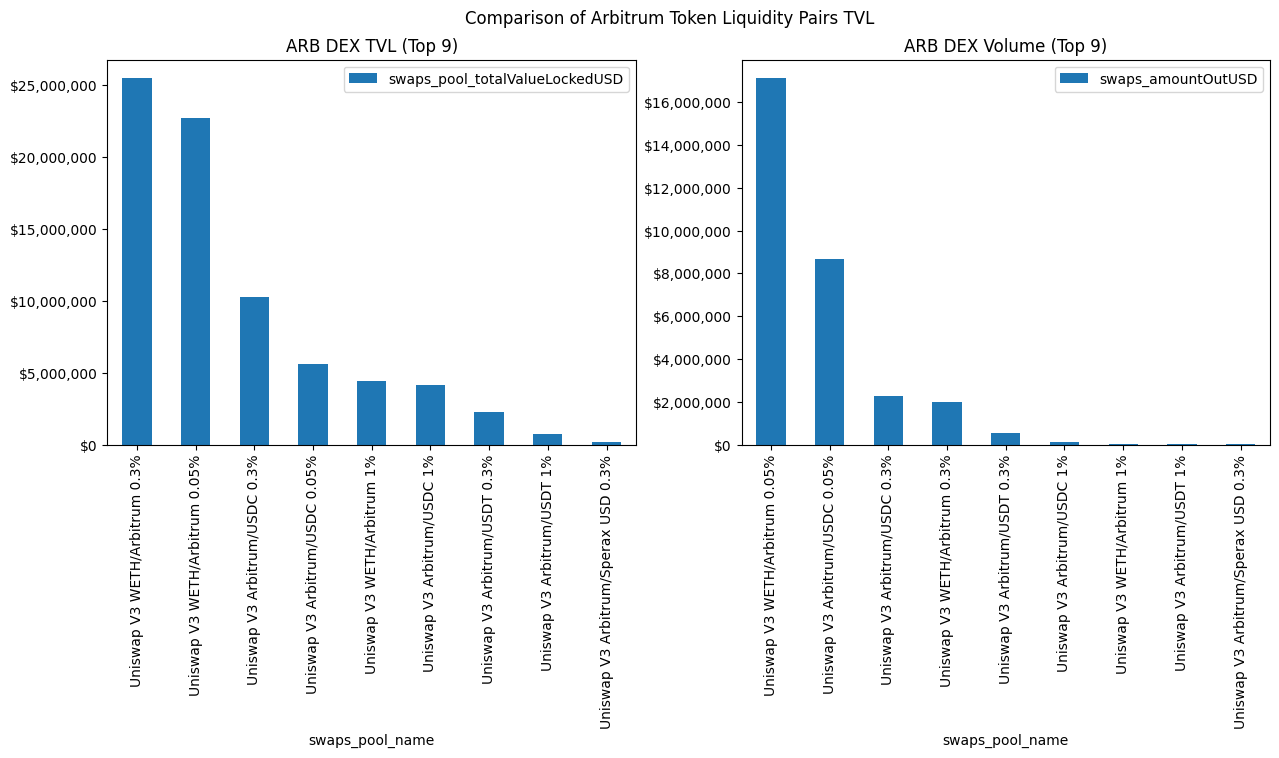

In [53]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot first bar chart on the first subplot
big_pools.to_pandas().plot(kind='bar', x='swaps_pool_name', y='swaps_pool_totalValueLockedUSD', ax=axes[0])
axes[0].set_title('ARB DEX TVL (Top 9)')
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) # Format y-axis

# Plot first bar chart on the first subplot
big_pools_sum.sort(by='swaps_amountOutUSD', reverse=True).to_pandas().plot(kind='bar', x='swaps_pool_name', y='swaps_amountOutUSD', ax=axes[1])
axes[1].set_title('ARB DEX Volume (Top 9)')
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) # Format y-axis

# Set common x-axis label for both subplots
fig.suptitle('Comparison of Arbitrum Token Liquidity Pairs TVL')
plt.show()


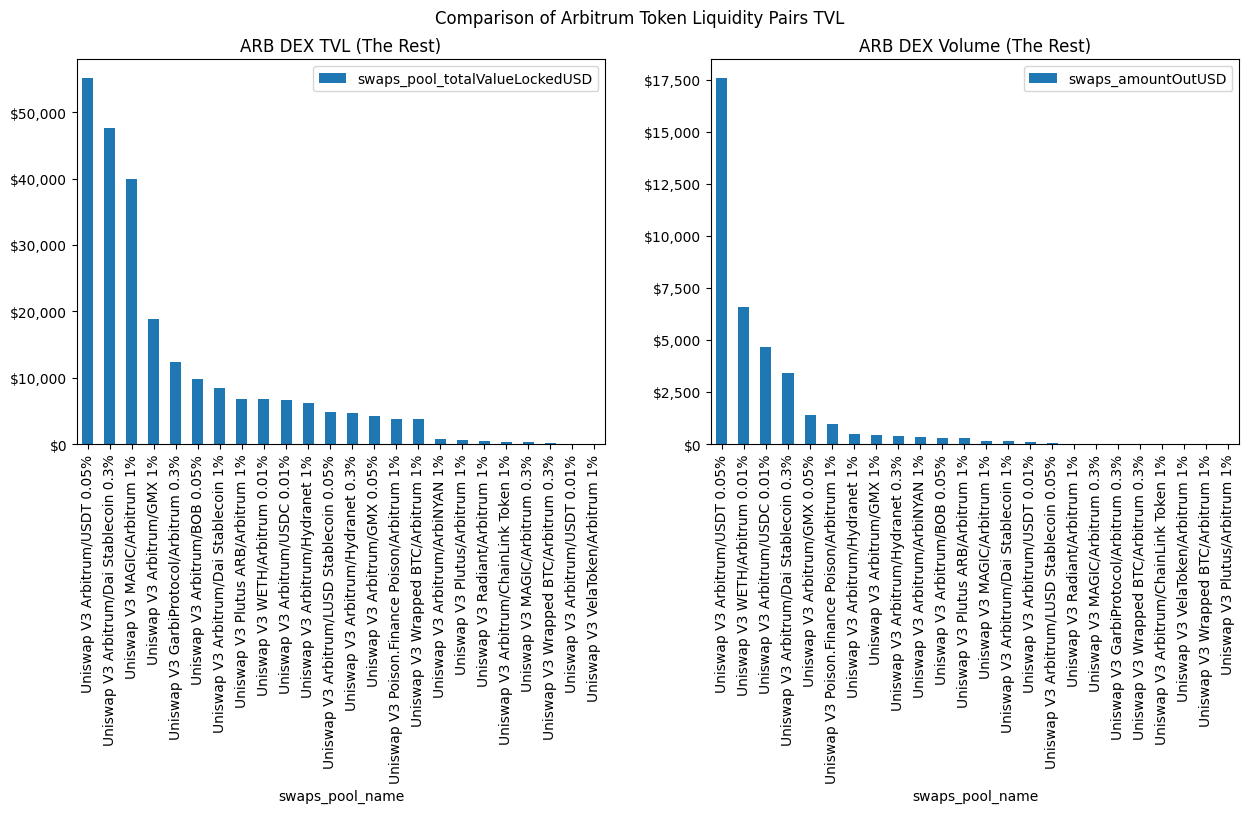

In [54]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot first bar chart on the second subplot
small_pools.to_pandas().plot(kind='bar', x='swaps_pool_name', y='swaps_pool_totalValueLockedUSD', ax=axes[0])
axes[0].set_title('ARB DEX TVL (The Rest)')
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) # Format y-axis

# Plot second bar chart on the second subplot
small_pools_sum.sort(by='swaps_amountOutUSD', reverse=True).to_pandas().plot(kind='bar', x='swaps_pool_name', y='swaps_amountOutUSD', ax=axes[1])
axes[1].set_title('ARB DEX Volume (The Rest)')
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}')) # Format y-axis

# Set common x-axis label for both subplots
fig.suptitle('Comparison of Arbitrum Token Liquidity Pairs TVL')
plt.show()